# Credit Risk — EDA (Structural Summary)

**Purpose.** High-level structure and quality snapshot of the raw datasets before detailed EDA.

**Datasets.**
- `applications` (Home Credit application_train)
- `bureau` (credit bureau tradelines)

This section reports: rows, columns, avg missing %, top missing columns, basic key integrity, and type mix


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.float_format = "{:.2f}".format

def type_mix(df: pd.DataFrame):
    return pd.Series({
        "n_numeric": int(df.select_dtypes(include=np.number).shape[1]),
        "n_categorical": int(df.select_dtypes(exclude=np.number).shape[1]),
        "n_bool": int(df.select_dtypes(include=["bool"]).shape[1]),
        "n_object": int(df.select_dtypes(include=["object"]).shape[1]),
    })

def key_check(df: pd.DataFrame, key_cols):
    out = {}
    for k in key_cols:
        if k in df.columns:
            out[f"{k}__exists"] = True
            out[f"{k}__unique_rows"] = df[k].is_unique
            out[f"{k}__nulls"] = int(df[k].isna().sum())
        else:
            out[f"{k}__exists"] = False
    return pd.Series(out)

def structural_summary(df: pd.DataFrame, name: str, key_cols=()):
    rows, cols = df.shape
    summary = pd.Series({
        "dataset": name,
        "rows": rows,
        "columns": cols,
        "avg_missing_pct": round(df.isna().mean().mean()*100, 2),
    })
    summary = pd.concat([summary, type_mix(df), key_check(df, key_cols)])
    return summary

In [ ]:
# Refer :- https://www.kaggle.com/rinnqd/reduce-memory-usage

def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type is not object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
applications = pd.read_csv("s3://crisk-nico-prod/raw/applications/application_train.csv.gz", compression='gzip')
bureau = pd.read_csv("s3://crisk-nico-prod/raw/bureau/bureau_raw.csv.gz", compression='gzip')

In [7]:
applications = reduce_memory_usage(applications)
bureau = reduce_memory_usage(bureau)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


In [8]:
apps_sum = structural_summary(applications, "applications", key_cols=["SK_ID_CURR"])
bureau_sum = structural_summary(bureau, "bureau", key_cols=["SK_ID_CURR", "SK_ID_BUREAU"])

summary_table = pd.DataFrame([apps_sum, bureau_sum])
display(summary_table)

,dataset,rows,columns,avg_missing_pct,n_numeric,n_categorical,n_bool,n_object,SK_ID_CURR__exists,SK_ID_CURR__unique_rows,SK_ID_CURR__nulls,SK_ID_BUREAU__exists,SK_ID_BUREAU__unique_rows,SK_ID_BUREAU__nulls
0,applications,307511,122,24.40,106,16,0,16,True,True,0,NaN,NaN,NaN
1,bureau,1716428,17,13.50,14,3,0,3,True,False,0,True,True,0.00


## Missing-Value Diagnostics

This section identifies:
1. Columns with high missing ratios.


In [9]:
def missing_barplot(df, topn=10):
    missing = df.isna().mean().sort_values(ascending=False)
    missing.head(topn).plot(kind='barh', figsize=(7,6))
    plt.title('Missing Values % (Applications)')
    plt.show()

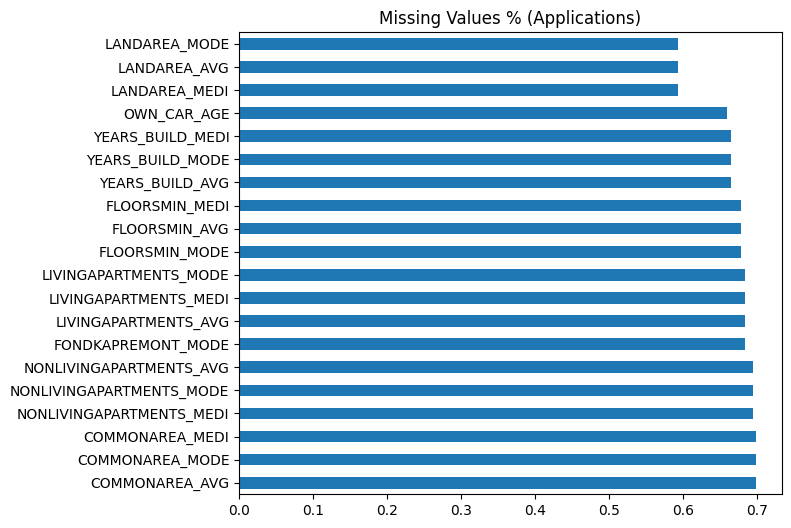

In [10]:
missing_barplot(applications, topn=20)

In [11]:
def missing_vs_target(df, target_col='TARGET'):
    """This function measures how the missingness of each feature is related to the target variable,
    showing both the percentage of missing values and how much the target mean changes between missing vs. non-missing rows."""
    res = []
    for col in df.columns:
        if df[col].isna().any() and col != target_col:
            miss_flag = df[col].isna().astype(int)
            default_gap = df.groupby(miss_flag)[target_col].mean().diff().iloc[-1]
            res.append((col, df[col].isna().mean()*100, default_gap))
    out = pd.DataFrame(res, columns=['feature','% missing_pct','default_gap']).sort_values('default_gap', ascending=False)
    return out

missing_influence = missing_vs_target(applications)
missing_influence.head(15)


,feature,% missing_pct,default_gap
63,AMT_REQ_CREDIT_BUREAU_WEEK,13.50,0.03
62,AMT_REQ_CREDIT_BUREAU_DAY,13.50,0.03
61,AMT_REQ_CREDIT_BUREAU_HOUR,13.50,0.03
66,AMT_REQ_CREDIT_BUREAU_YEAR,13.50,0.03
65,AMT_REQ_CREDIT_BUREAU_QRT,13.50,0.03
64,AMT_REQ_CREDIT_BUREAU_MON,13.50,0.03
55,EMERGENCYSTATE_MODE,47.40,0.02
53,TOTALAREA_MODE,48.27,0.02
15,ENTRANCES_AVG,50.35,0.02
43,ENTRANCES_MEDI,50.35,0.02


Many features have moderate to high missingness (13–50%). The positive default_gap values show that missing values tend to be associated with a slightly higher default rate.

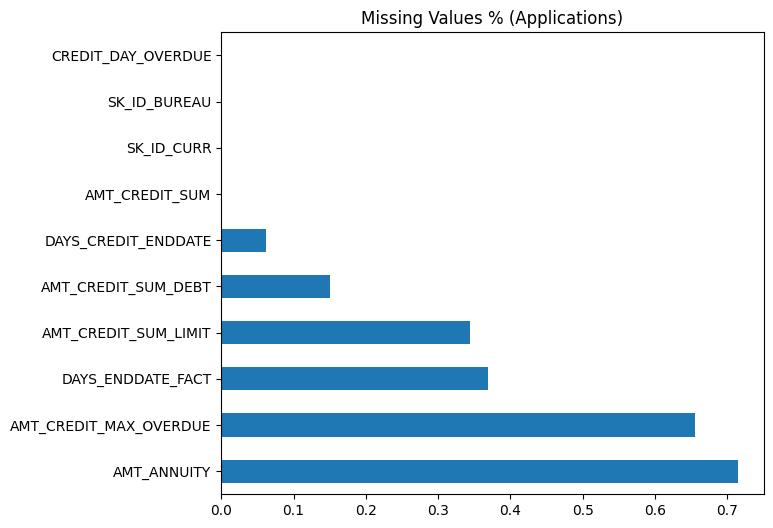

In [12]:
missing_barplot(bureau)

## Correlation Matrix & Redundancy Check

Goal:
1. Detect multicollinearity variables carrying the same signal.
2. Identify groups of correlated features to simplify feature selection before modeling.
3. Flag numeric features that can be dropped or combined.

Approach:
- Compute a Pearson correlation matrix for numerical columns.
- Visualize top correlations as a heatmap.
- List pairs with |corr| > 0.9 (potential redundancy).


In [ ]:
import numpy as np
import seaborn as sns

def correlation_redundancy(top_n):
    # Numeric correlation matrix
    num_df = applications.select_dtypes(include=[np.number]).copy()
    
    # Drop TARGET temporarily
    target_corr = num_df.corr(numeric_only=True)["TARGET"].drop("TARGET", errors="ignore").sort_values(key=abs, ascending=False)
    print(f"Top {top_n} correlations with TARGET:\n")
    display(target_corr.head(top_n))

    # Full correlation matrix (Pearson)
    corr_matrix = num_df.corr(numeric_only=True)

    # Zoom into top 25 numeric columns by variance
    top_vars = num_df.var().sort_values(ascending=False).head(top_n).index
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix.loc[top_vars, top_vars], cmap="coolwarm", center=0, annot=False)
    plt.title(f"Top {top_n} Variables — Correlation Heatmap")
    plt.show()

    # Redundancy check (|corr| > 0.9)
    threshold = 0.9
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ["feature_1", "feature_2", "corr"]
    high_corr = corr_pairs.loc[corr_pairs["corr"].abs() > threshold].sort_values("corr", ascending=False)
    display(high_corr.head(top_n))
    print(f"\n{len(high_corr)} pairs have correlation > {threshold}")


Top 15 correlations with TARGET:



EXT_SOURCE_3                  -0.18
EXT_SOURCE_2                  -0.16
EXT_SOURCE_1                  -0.16
DAYS_BIRTH                     0.08
REGION_RATING_CLIENT_W_CITY    0.06
REGION_RATING_CLIENT           0.06
DAYS_LAST_PHONE_CHANGE         0.06
DAYS_ID_PUBLISH                0.05
REG_CITY_NOT_WORK_CITY         0.05
FLAG_EMP_PHONE                 0.05
DAYS_EMPLOYED                 -0.04
REG_CITY_NOT_LIVE_CITY         0.04
FLAG_DOCUMENT_3                0.04
FLOORSMAX_AVG                 -0.04
FLOORSMAX_MEDI                -0.04
Name: TARGET, dtype: float64

c:\Python311\Lib\site-packages\pandas\core\nanops.py:1496: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


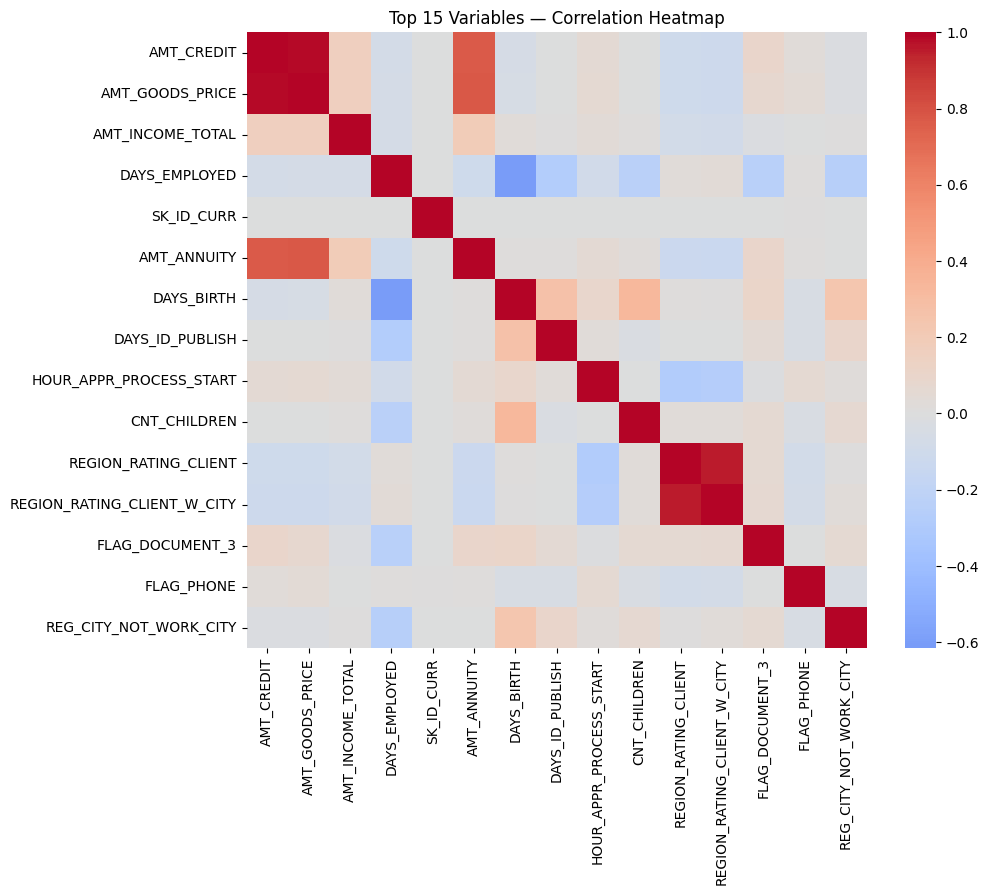

,feature_1,feature_2,corr
3078,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,1.00
5072,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,1.00
3418,FLOORSMIN_AVG,FLOORSMIN_MEDI,1.00
3352,FLOORSMAX_AVG,FLOORSMAX_MEDI,1.00
3285,ENTRANCES_AVG,ENTRANCES_MEDI,1.00
3217,ELEVATORS_AVG,ELEVATORS_MEDI,1.00
3148,COMMONAREA_AVG,COMMONAREA_MEDI,1.00
3610,LIVINGAREA_AVG,LIVINGAREA_MEDI,1.00
2862,APARTMENTS_AVG,APARTMENTS_MEDI,1.00
2935,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,0.99



62 pairs have correlation > 0.9


In [14]:
correlation_redundancy(top_n=15)

## Target Distribution

1. Compare Target distribution

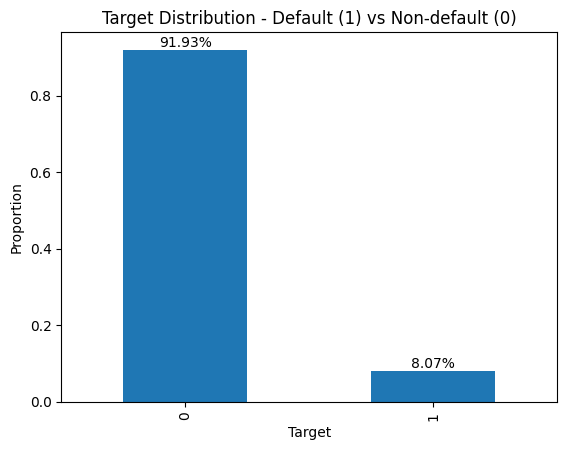

In [15]:
ax = applications['TARGET'].value_counts(normalize=True).plot(kind='bar')

plt.title('Target Distribution - Default (1) vs Non-default (0)')
plt.xlabel('Target')
plt.ylabel('Proportion')

for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, 
            i.get_height(),                  
            f'{i.get_height():.2%}',                 
            ha='center', va='bottom', fontsize=10)
plt.show()


# APPLICATIONS DATASET ANALYSIS

### CATEGORICAL ANALYSIS

Here, we are going to analyze the categorical features from applications dataset. To get insights based on different attributes and the Target feature (Default and non-default)

,Non-default (0),Default (1),% Non-default,% Default
NAME_CONTRACT_TYPE,,,,
Cash loans,255011,23221,91.65%,8.35%
Revolving loans,27675,1604,94.52%,5.48%


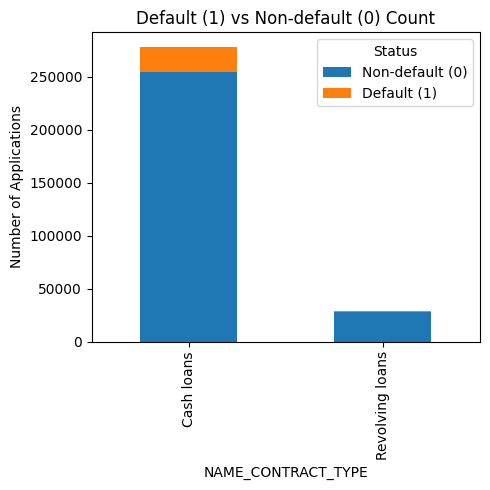

In [ ]:
# Compute counts per contract type and target
def stack_plot(data, xtick, target='TARGET'):
    counts = data.groupby([xtick, target]).size().unstack(fill_value=0)
    counts.columns = ['Non-default (0)', 'Default (1)']

    # Compute percentages (row-wise)
    rates = counts.div(counts.sum(axis=1), axis=0) * 100
    rates = rates.map(lambda x: f'{x:.2f}%')
    rates.columns = ['% Non-default', '% Default']

    # Combine both counts and percentages into one DataFrame (for reference)
    summary = pd.concat([counts, rates], axis=1)

    display(summary)

    counts.plot(
        kind='bar', stacked=True, figsize=(5,5)
    )

    plt.title('Default (1) vs Non-default (0) Count')
    plt.ylabel('Number of Applications')
    plt.legend(title='Status', loc='upper right')

    plt.tight_layout()
    plt.show()

stack_plot(applications, xtick='NAME_CONTRACT_TYPE')


The majority of applicants request cash loans (approximately 92% of total). This segment also exhibits a higher default rate (8.35%), consistent with its higher credit exposure and lower collateralization. In contrast, revolving loans show stronger repayment performance (5.5% default rate).

,Non-default (0),Default (1),% Non-default,% Default
CODE_GENDER,,,,
F,188278,14170,93.00%,7.00%
M,94404,10655,89.86%,10.14%
XNA,4,0,100.00%,0.00%


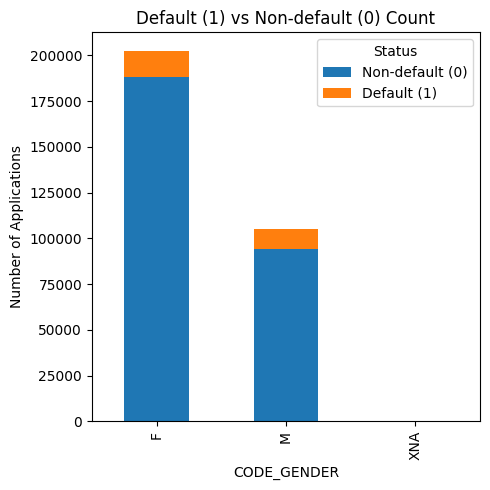

In [17]:
stack_plot(applications, xtick='CODE_GENDER')

Female applicants represent the majority of the portfolio. Male borrowers show a higher probability of default (10.1% vs. 7.0%). The rare ‘XNA’ gender category (just 4) is excluded due to negligible sample size.

,Non-default (0),Default (1),% Non-default,% Default
REGION_RATING_CLIENT,,,,
1,30645,1552,95.18%,4.82%
2,209077,17907,92.11%,7.89%
3,42964,5366,88.90%,11.10%


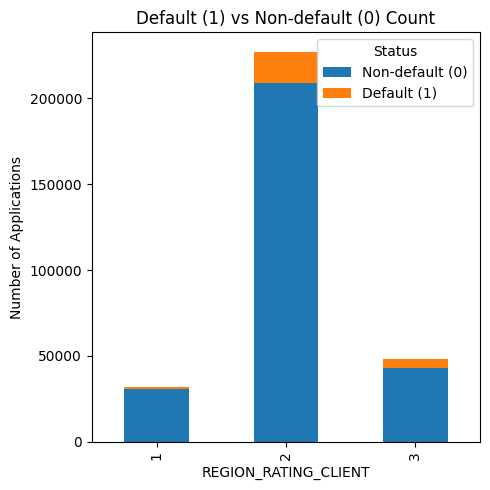

In [18]:
stack_plot(applications, xtick='REGION_RATING_CLIENT')

Regional rating is strongly associated with credit performance: borrowers from higher-risk regions (rating 3) show an 11% default rate compared to only 4.8% in the lowest-risk regions (rating 1).

,Non-default (0),Default (1),% Non-default,% Default
REGION_RATING_CLIENT_W_CITY,,,,
1,32513,1654,95.16%,4.84%
2,211314,18170,92.08%,7.92%
3,38859,5001,88.60%,11.40%


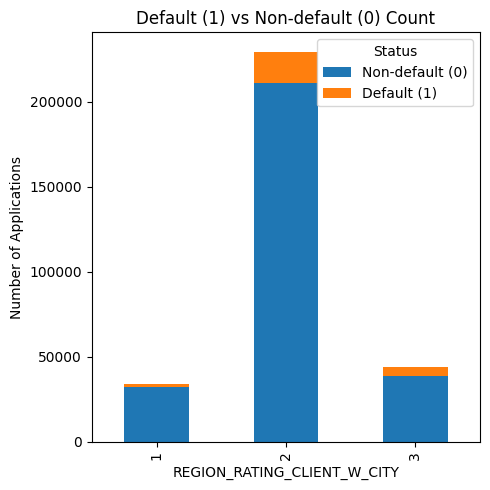

In [19]:
stack_plot(applications, xtick='REGION_RATING_CLIENT_W_CITY')

Same pattern as the previous feature, confirming the robustness of the region-related rating in explaining defaults. Both features are highly correlated, we might keep only one to avoid redundancy.

,Non-default (0),Default (1),% Non-default,% Default
FLAG_OWN_CAR,,,,
N,185675,17249,91.50%,8.50%
Y,97011,7576,92.76%,7.24%


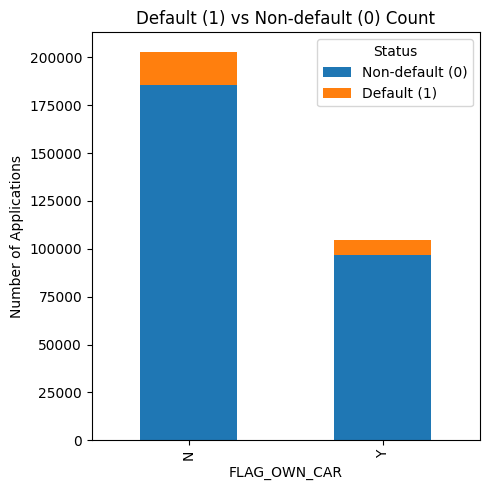

In [20]:
stack_plot(applications, xtick='FLAG_OWN_CAR')

Car ownership is moderately prevalent (34%) but exhibits minimal influence on default risk (8.5% vs. 7.2%). Similarly, home ownership shows limited differentiation.

,Non-default (0),Default (1),% Non-default,% Default
FLAG_OWN_REALTY,,,,
N,86357,7842,91.68%,8.32%
Y,196329,16983,92.04%,7.96%


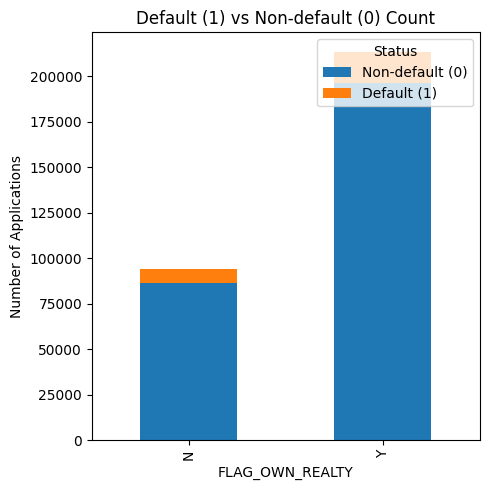

In [21]:
stack_plot(applications, xtick='FLAG_OWN_REALTY')

As the last feature, the probability of default are equal than non-default, the effect is minor. But people with own realty trends to apply for a loan.

,Non-default (0),Default (1),% Non-default,% Default
NAME_EDUCATION_TYPE,,,,
Academic degree,161,3,98.17%,1.83%
Higher education,70854,4009,94.64%,5.36%
Incomplete higher,9405,872,91.52%,8.48%
Lower secondary,3399,417,89.07%,10.93%
Secondary / secondary special,198867,19524,91.06%,8.94%


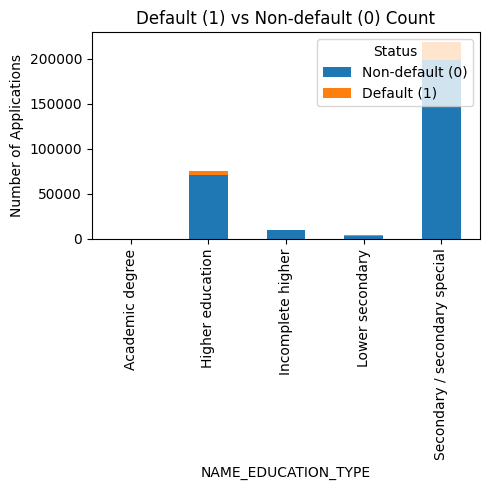

In [22]:
stack_plot(applications, xtick='NAME_EDUCATION_TYPE')

It is clear that the higher the education, the lower the default rate. This could link to better financial literacy or higher/stable incomes.

In [23]:
def stack_multiple_plot(data, xtick, target = 'TARGET'):

    counts = (
        data.groupby([xtick, target])
        .size()
        .unstack(fill_value=0)
        .rename(columns={0: 'Non-default (0)', 1: 'Default (1)'})
    )

    summary = counts.copy()
    summary['% Default'] = (summary['Default (1)'] / summary.sum(axis=1) * 100)
    summary['% Non-default'] = 100 - summary['% Default']

    summary = summary.sort_values('% Default', ascending=False)

    summary['% Default'] = summary['% Default'].round(2).astype(str) + '%'
    summary['% Non-default'] = summary['% Non-default'].round(2).astype(str) + '%'

    display(summary[['Non-default (0)', 'Default (1)', '% Non-default', '% Default']])

    plot_counts = counts.sort_values(['Non-default (0)']+['Default (1)'])

    fig, ax = plt.subplots(figsize=(8,5))
    plot_counts.plot(kind='barh', stacked=True, ax=ax)

    ax.set_title('Default (1) vs Non-default (0) Count')
    ax.set_xlabel('Number of Applications')
    ax.legend(title='Status', loc='lower right')

    plt.tight_layout()
    plt.show()

TARGET,Non-default (0),Default (1),% Non-default,% Default
CNT_CHILDREN,,,,
9,0,2,0.0%,100.0%
11,0,1,0.0%,100.0%
6,15,6,71.43%,28.57%
4,374,55,87.18%,12.82%
3,3359,358,90.37%,9.63%
1,55665,5454,91.08%,8.92%
2,24416,2333,91.28%,8.72%
5,77,7,91.67%,8.33%
0,198762,16609,92.29%,7.71%


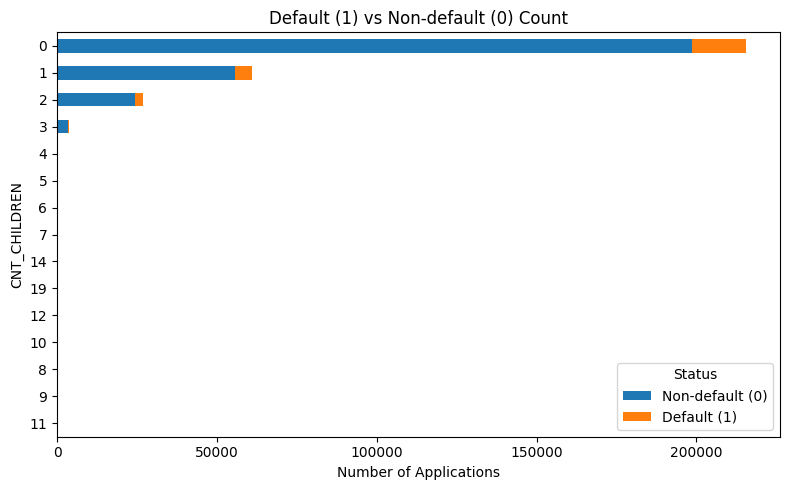

In [24]:
stack_multiple_plot(applications, xtick='CNT_CHILDREN')

Default probability increases with the number of dependents, reflecting greater financial obligations. Applicants with four or more children default at rates exceeding 12%. Given the small number of extreme cases (>5 children), grouping them under a single “4+ children” category will improve feature stability.

TARGET,Non-default (0),Default (1),% Non-default,% Default
NAME_INCOME_TYPE,,,,
Maternity leave,3,2,60.0%,40.0%
Unemployed,14,8,63.64%,36.36%
Working,143550,15224,90.41%,9.59%
Commercial associate,66257,5360,92.52%,7.48%
State servant,20454,1249,94.25%,5.75%
Pensioner,52380,2982,94.61%,5.39%
Businessman,10,0,100.0%,0.0%
Student,18,0,100.0%,0.0%


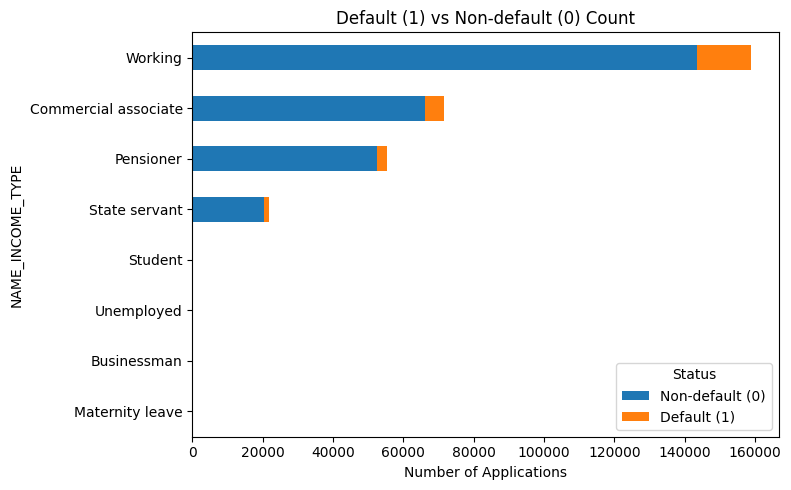

In [25]:
stack_multiple_plot(applications, xtick='NAME_INCOME_TYPE')

Employment type is among the most discriminative features. Borrowers with unstable or no income sources (unemployed, on maternity leave) exhibit  elevated default rates (30–40%), although it has few applicants. On the other hand, pensioners and state servants present the lowest risk profiles (<6% default rate).

TARGET,Non-default (0),Default (1),% Non-default,% Default
NAME_FAMILY_STATUS,,,,
Civil marriage,26814,2961,90.06%,9.94%
Single / not married,40987,4457,90.19%,9.81%
Separated,18150,1620,91.81%,8.19%
Married,181582,14850,92.44%,7.56%
Widow,15151,937,94.18%,5.82%
Unknown,2,0,100.0%,0.0%


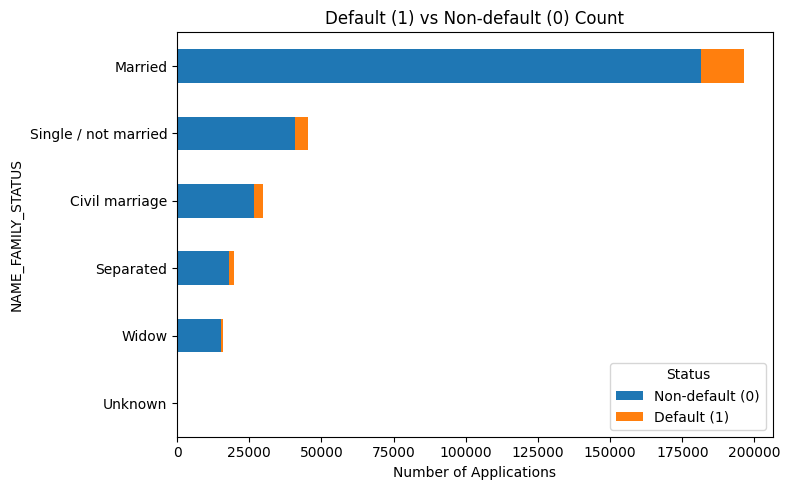

In [26]:
stack_multiple_plot(applications, xtick='NAME_FAMILY_STATUS')

Marital status correlates inversely with default risk. Married and widowed borrowers show the lowest default rates (6–7%), suggesting higher financial stability or shared household income. In contrast, single or informally partnered individuals default more frequently (around 10%).

TARGET,Non-default (0),Default (1),% Non-default,% Default
NAME_HOUSING_TYPE,,,,
Rented apartment,4280,601,87.69%,12.31%
With parents,13104,1736,88.3%,11.7%
Municipal apartment,10228,955,91.46%,8.54%
Co-op apartment,1033,89,92.07%,7.93%
House / apartment,251596,21272,92.2%,7.8%
Office apartment,2445,172,93.43%,6.57%


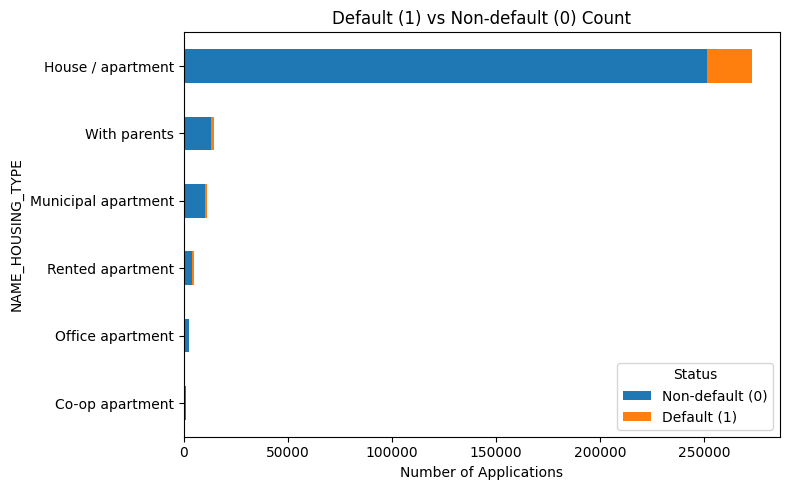

In [27]:
stack_multiple_plot(applications, xtick='NAME_HOUSING_TYPE')

Housing status differentiates credit behavior: renters and applicants living with parents show significantly higher default rates (11–12%), while those owning or occupying standard apartments perform better (less than 8%). Homeownership appears to reinforce financial commitment and repayment discipline.

TARGET,Non-default (0),Default (1),% Non-default,% Default
OCCUPATION_TYPE,,,,
Low-skill Laborers,1734,359,82.85%,17.15%
Drivers,16496,2107,88.67%,11.33%
Waiters/barmen staff,1196,152,88.72%,11.28%
Security staff,5999,722,89.26%,10.74%
Laborers,49348,5838,89.42%,10.58%
Cooking staff,5325,621,89.56%,10.44%
Sales staff,29010,3092,90.37%,9.63%
Cleaning staff,4206,447,90.39%,9.61%
Realty agents,692,59,92.14%,7.86%


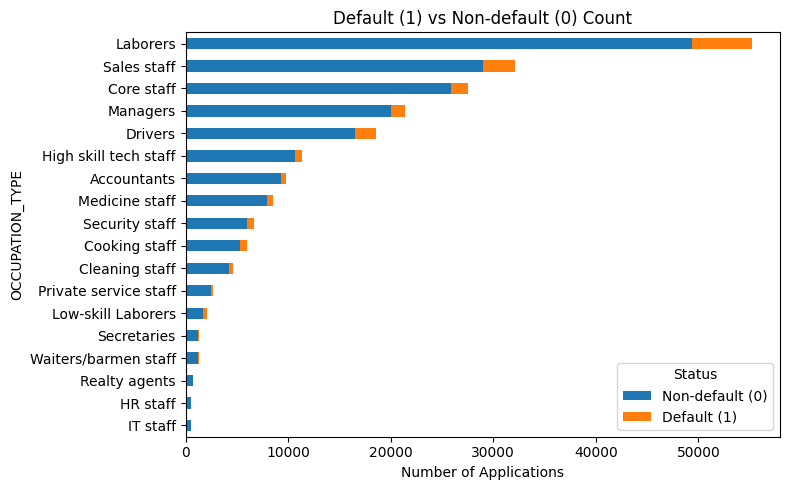

In [28]:
stack_multiple_plot(applications, 'OCCUPATION_TYPE')

There’s a clear income-stability gradient, lower-skill or manual workers default significantly more.
Occupations with higher education or steady salaries (e.g., IT, Accounting, HR) show much better credit behavior.

### NUMERICAL ANALYSIS

Now, lets evaluate the numerical analysis, to get patterns from numerical data and if they are related to defaults.

In [ ]:
def hist_boxplot_numerical(data, xtick, target='TARGET', log_boxplot=True, trim_quantile=1.0):

    data = data.copy()
    data[xtick] = data[xtick].abs()

    display(data.groupby(target)[xtick].describe().T)
    
    # Trim outliers (top x%)
    q_high = data[xtick].quantile(trim_quantile)
    df_trim = data[data[xtick] <= q_high]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Left: Histogram ---
    sns.histplot(
        data=df_trim,
        x=xtick,
        hue=target,
        bins=50,
        stat='density',
        common_norm=False,
        kde=True,
        alpha=0.5,
        ax=axes[0]
    )
    axes[0].set_title(f'{xtick} Distribution by Default Status \n(Quantile excluded: {(1 - trim_quantile) * 100:.1f}%, Normalized)')
    axes[0].set_xlabel(xtick)
    axes[0].set_ylabel('Density')
    axes[0].legend(title=target, labels=['Non-default (0)', 'Default (1)'])

    # --- Right: Boxplot ---
    sns.boxplot(data=data, x=target, y=xtick, ax=axes[1])
    if log_boxplot:
        axes[1].set_yscale('log')
    axes[1].set_title(f'{xtick} by Default Status (Boxplot{" - Log Scale" if log_boxplot else ""})')
    axes[1].set_xlabel(target)
    axes[1].set_ylabel(xtick)

    plt.tight_layout()
    plt.show()

TARGET,0,1
count,282686.00,24825.00
mean,169077.73,165611.77
std,110476.27,746676.94
min,25650.00,25650.00
25%,112500.00,112500.00
50%,148500.00,135000.00
75%,202500.00,202500.00
max,18000090.00,117000000.00


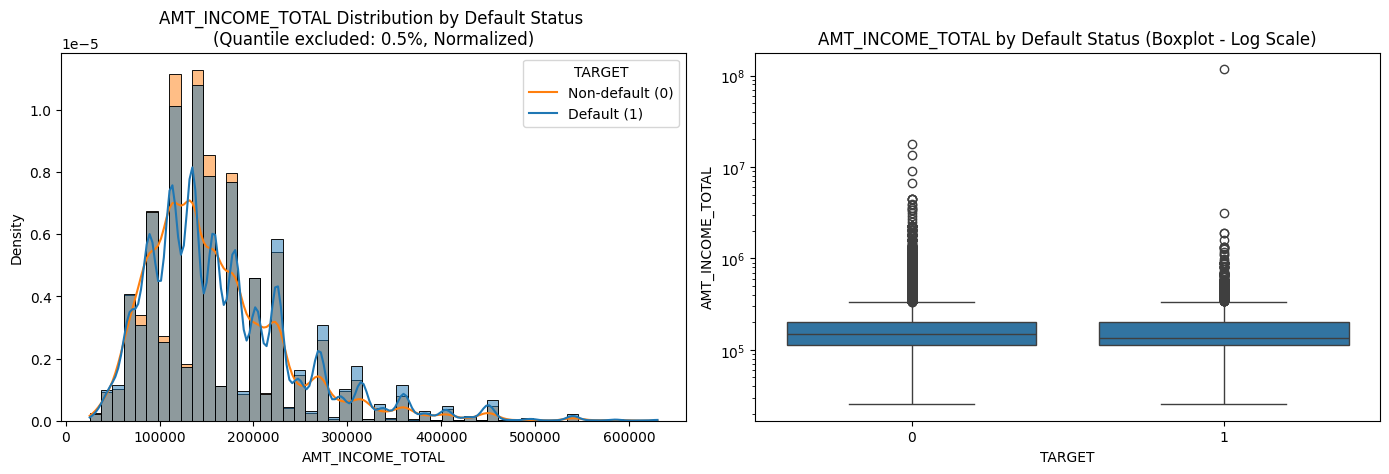

In [31]:
hist_boxplot_numerical(applications, 'AMT_INCOME_TOTAL', trim_quantile=0.995)

TARGET,0,1
count,282674.00,24825.00
mean,27163.62,26481.74
std,14658.31,12450.68
min,1615.50,2722.50
25%,16456.50,17361.00
50%,24876.00,25263.00
75%,34749.00,32976.00
max,258025.50,149211.00


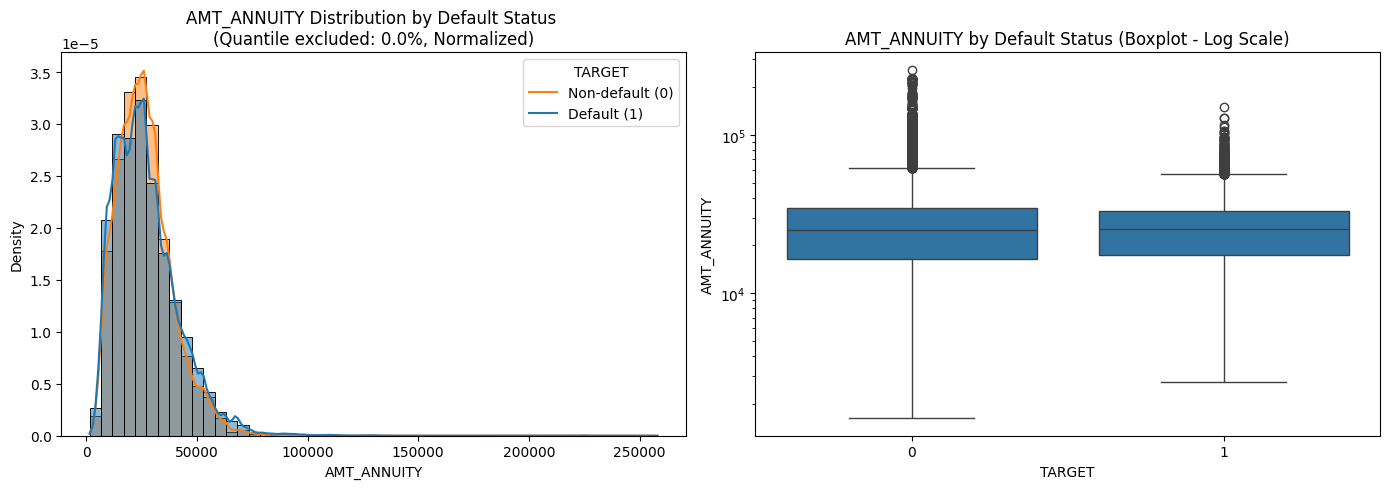

In [32]:
hist_boxplot_numerical(applications, 'AMT_ANNUITY')

TARGET,0,1
count,282686.00,24825.00
mean,69668.81,45587.32
std,140983.36,118303.30
min,0.00,0.00
25%,967.00,677.00
50%,2304.00,1458.00
75%,6074.00,3280.00
max,365243.00,365243.00


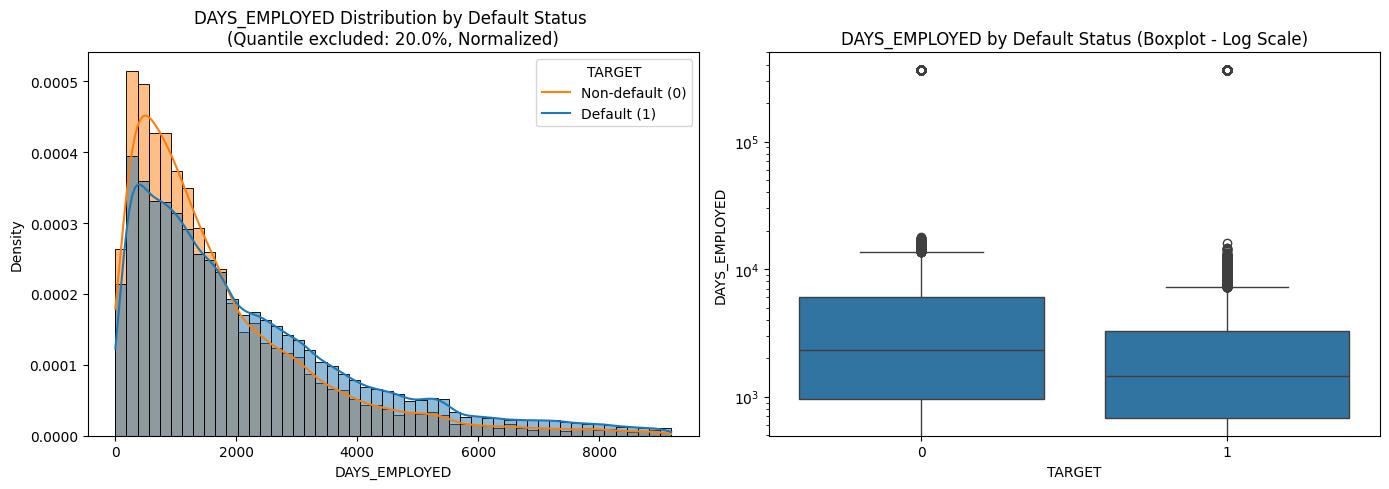

In [33]:
hist_boxplot_numerical(applications, 'DAYS_EMPLOYED', trim_quantile=0.80)

c:\Python311\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


TARGET,0,1
count,124079.00,10054.00
mean,0.00,0.39
std,0.00,0.20
min,0.01,0.01
25%,0.35,0.22
50%,0.52,0.36
75%,0.68,0.54
max,0.96,0.93


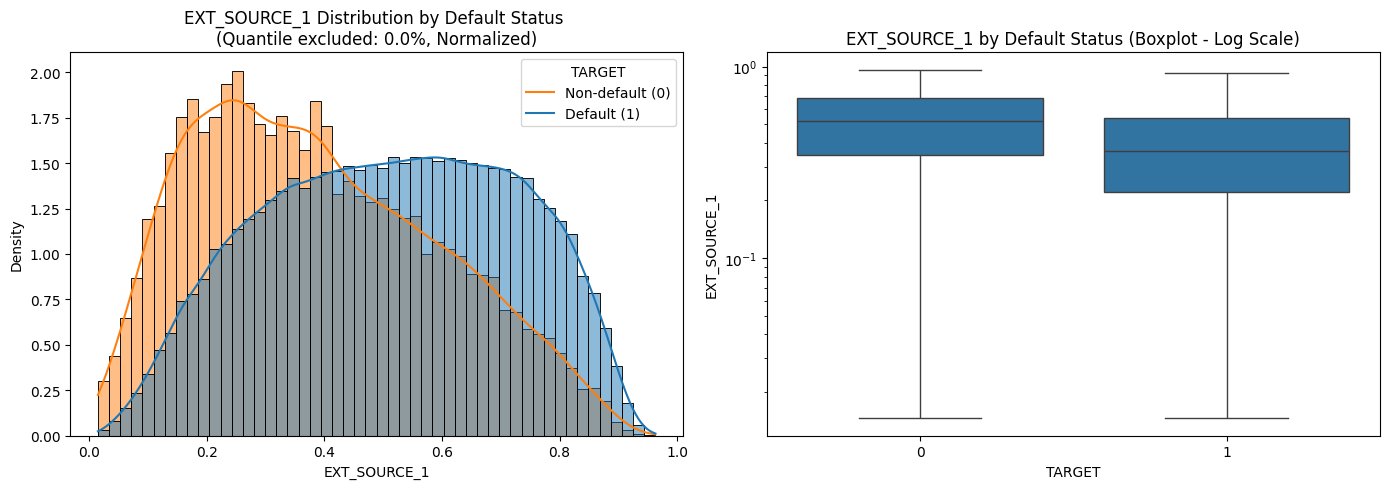

In [34]:
hist_boxplot_numerical(applications, 'EXT_SOURCE_1')

c:\Python311\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Python311\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Python311\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


TARGET,0,1
count,282078.00,24773.00
mean,NaN,0.41
std,0.00,0.21
min,0.00,0.00
25%,0.41,0.24
50%,0.57,0.44
75%,0.67,0.59
max,0.85,0.81


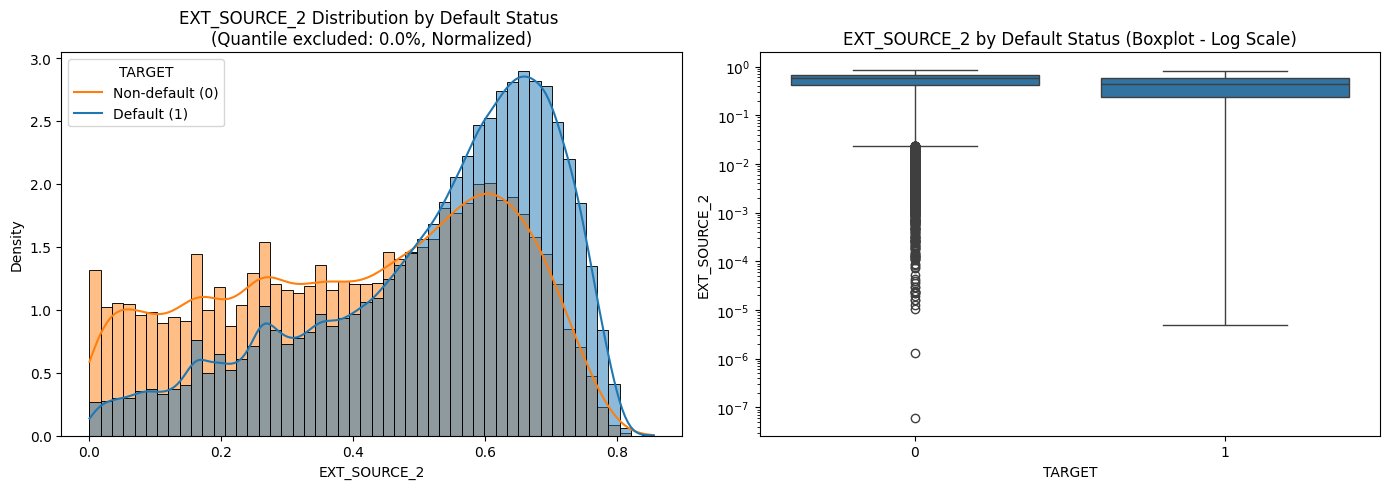

In [35]:
hist_boxplot_numerical(applications, 'EXT_SOURCE_2')

c:\Python311\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Python311\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Python311\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


TARGET,0,1
count,227398.00,19148.00
mean,NaN,0.39
std,0.00,0.21
min,0.00,0.00
25%,0.39,0.22
50%,0.55,0.38
75%,0.67,0.55
max,0.89,0.90


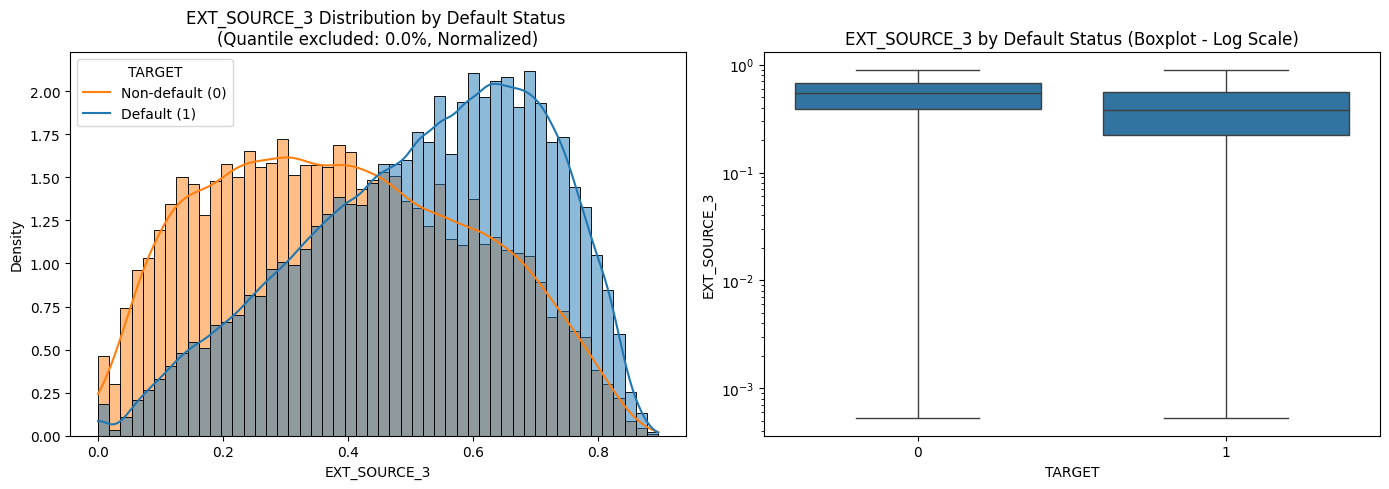

In [36]:
hist_boxplot_numerical(applications, 'EXT_SOURCE_3')

TARGET,0,1
count,282429.00,24804.00
mean,542736.88,488972.44
std,373785.50,311636.50
min,40500.00,45000.00
25%,238500.00,238500.00
50%,450000.00,450000.00
75%,688500.00,675000.00
max,4050000.00,3600000.00


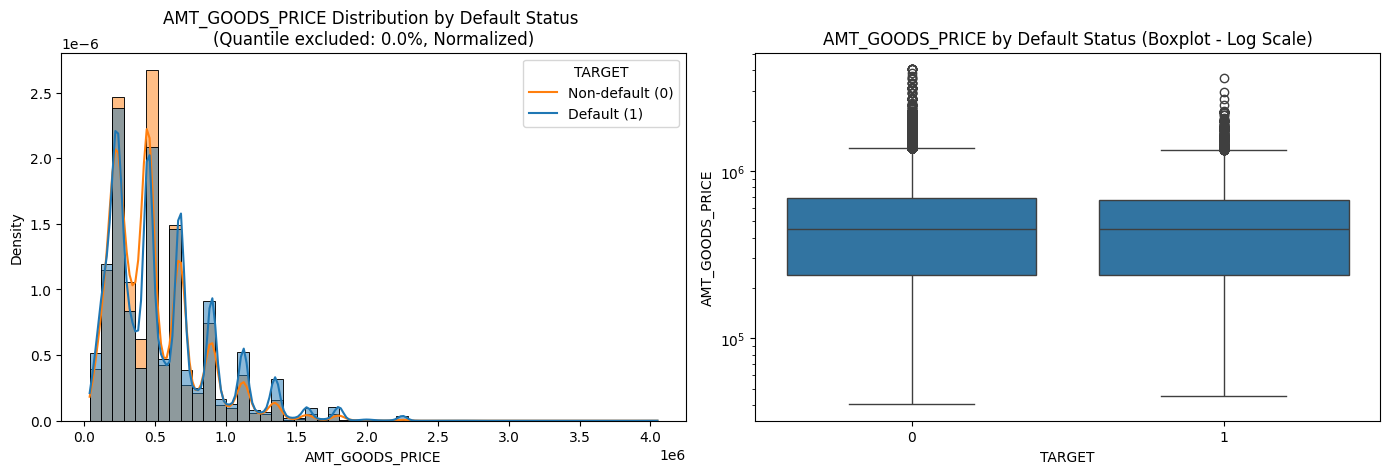

In [37]:
hist_boxplot_numerical(applications, 'AMT_GOODS_PRICE')

TARGET,0,1
count,282686.00,24825.00
mean,16138.18,14884.83
std,4364.20,4192.84
min,7489.00,7678.00
25%,12536.00,11396.00
50%,15877.00,14282.00
75%,19793.75,18037.00
max,25229.00,25168.00


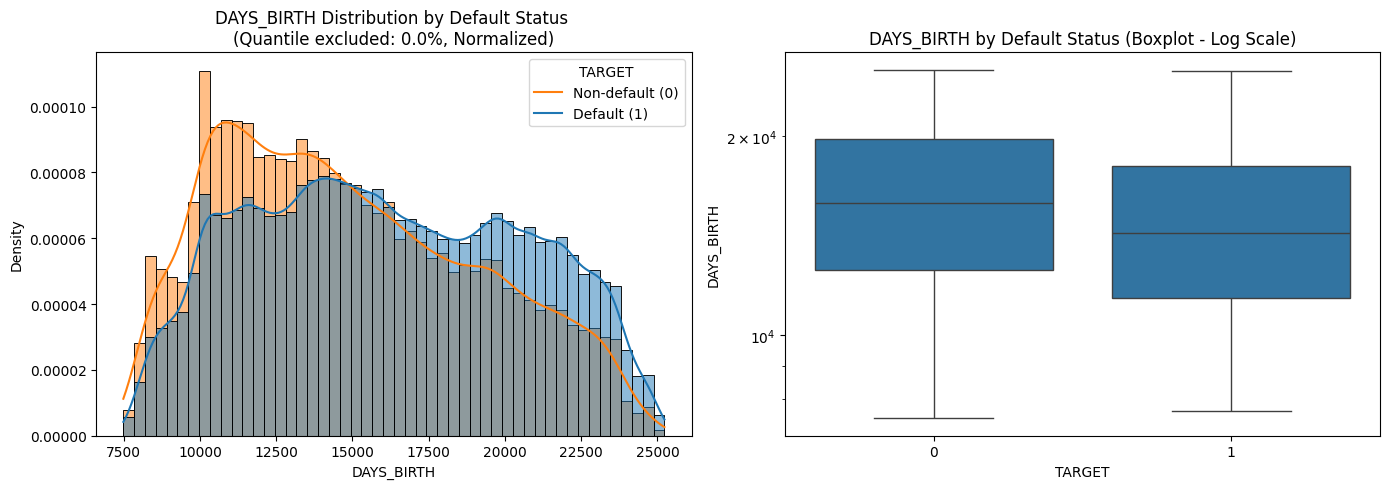

In [38]:
hist_boxplot_numerical(applications, 'DAYS_BIRTH')

TARGET,0,1
count,282686.00,24825.00
mean,602648.31,557778.50
std,406845.91,346433.25
min,45000.00,45000.00
25%,270000.00,284400.00
50%,517788.00,497520.00
75%,810000.00,733315.50
max,4050000.00,4027680.00


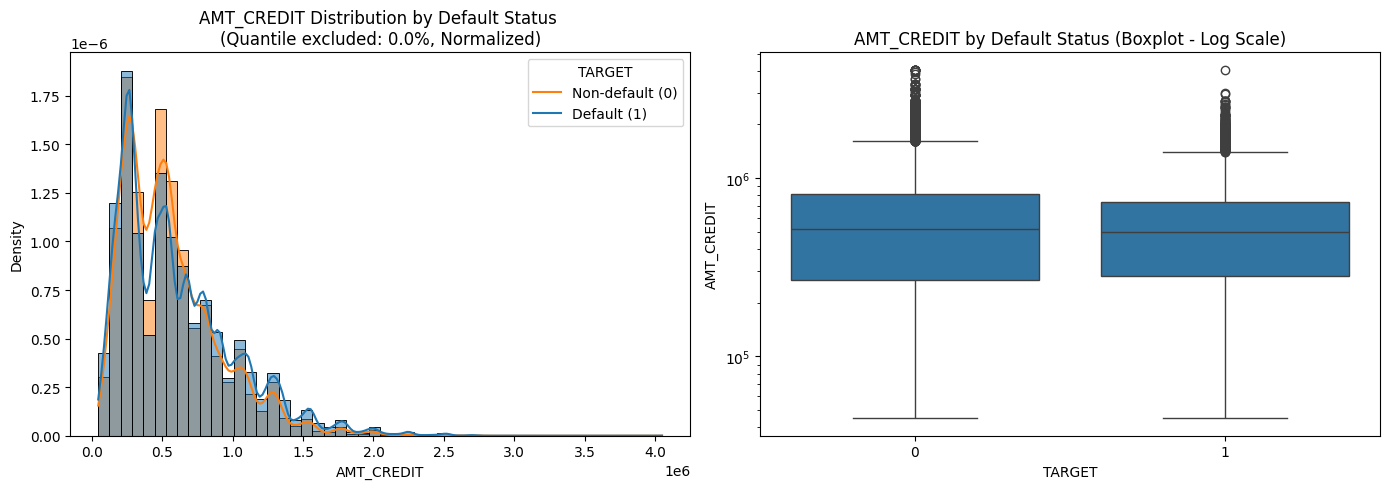

In [39]:
hist_boxplot_numerical(applications, 'AMT_CREDIT')

# BUREAU DATASET ANALYSIS

### CATEGORICAL ANALYSIS

Let’s evaluate the Bureau dataset to gain historical insights into customers’ relationships with other financial institutions. Through a categorical analysis, we will identify which types of data are most prevalent.

In [40]:
def single_stack_plot(data, xtick):
    counts = data[xtick].value_counts()

    display(counts.to_frame(name='Count')
            )
    plt.figure(figsize=(10,5))
    counts.sort_values().plot(kind='barh')
    plt.title(f'{xtick} Distribution')
    plt.xlabel('Count')
    plt.ylabel(xtick)
    plt.tight_layout()
    plt.show()

,Count
CREDIT_ACTIVE,
Closed,1079273
Active,630607
Sold,6527
Bad debt,21


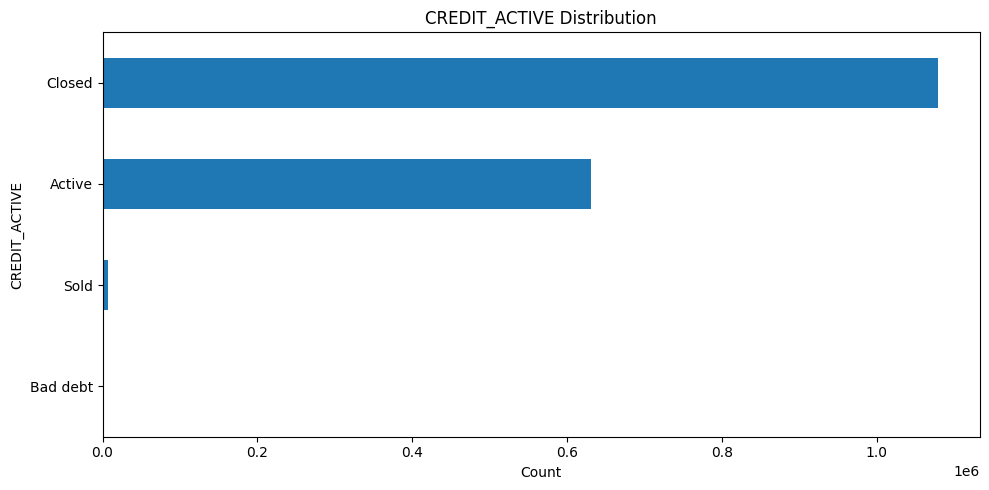

In [41]:
single_stack_plot(bureau, 'CREDIT_ACTIVE')

The majority of past credit are Closed, meanwhile there is a significant of Active credits. Most clients have completed loans but many still carry ongoing debt obligations. We can aggregate this by costumer to later be merged with `applications` and analyze them by TARGET.

In [42]:
active_loans = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').size()
closed_loans = bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').size()

,Count
CREDIT_CURRENCY,
currency 1,1715020
currency 2,1224
currency 3,174
currency 4,10


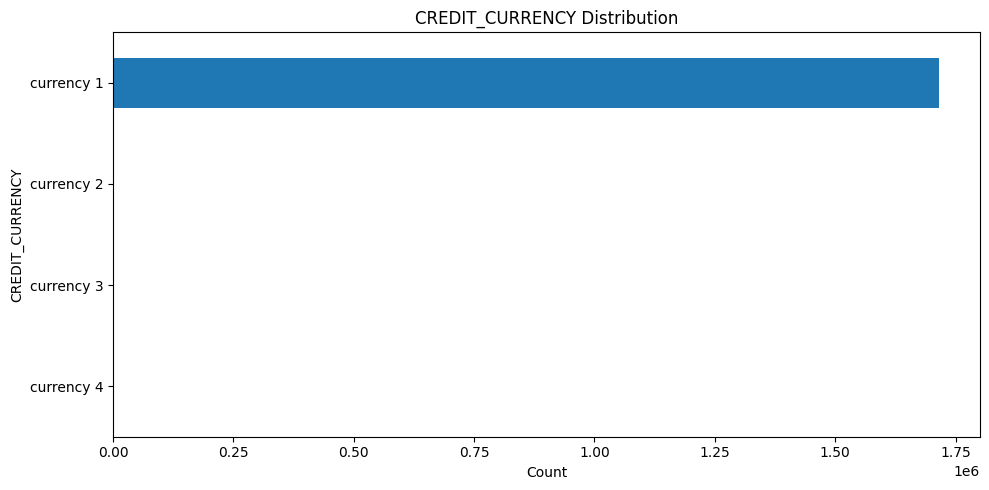

In [43]:
single_stack_plot(bureau, 'CREDIT_CURRENCY')

Currency 1 dominates the majority, that means that almost all records use Currency 1 (could be the local currency). However, it does not contributes meaningful variance. It lacks of variability.

,Count
CREDIT_TYPE,
Consumer credit,1251615
Credit card,402195
Car loan,27690
Mortgage,18391
Microloan,12413
Loan for business development,1975
Another type of loan,1017
Unknown type of loan,555
Loan for working capital replenishment,469


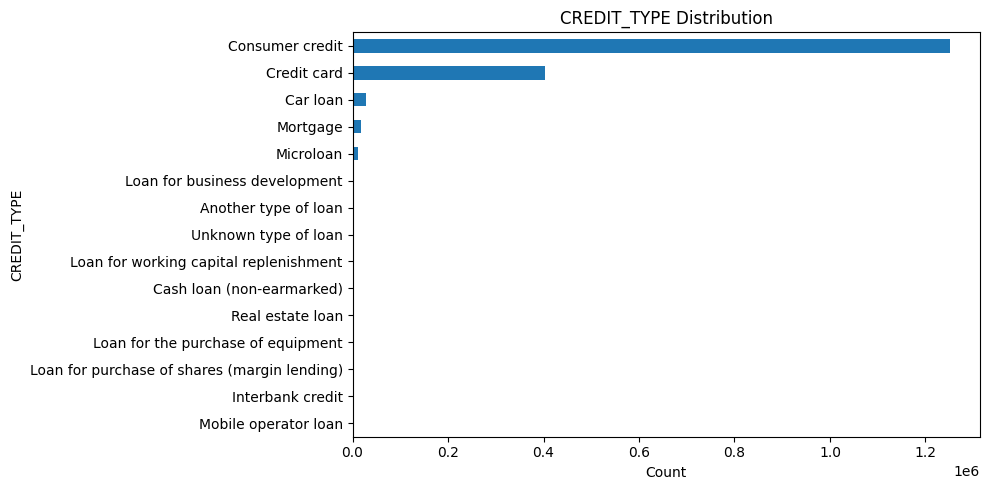

In [44]:
single_stack_plot(bureau, 'CREDIT_TYPE')

The portfolio is dominated by consumer credit and credit card loans. Car loan and Mortgage are smaller in volume. We will aggregate Credit type by client to later be merged with `applications` and analyze them by TARGET.

### NUMERICAL ANALYSIS

For numerical analysis, we are going to evaluate different graphs to get any useful tendencies.

In [ ]:
def hist_boxplot_numeric(data, col, log_boxplot=False, trim_upper=1.0):
    """Univariate numeric EDA for bureau without TARGET."""
    s = data[col].dropna().astype(float).copy()

    # optional trimming (top 0.5% by default)
    q = s.quantile(trim_upper)
    s_trim = s[s <= q]

    display(s.describe().to_frame(col))

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # histogram + KDE
    sns.histplot(np.log1p(s_trim) if log_boxplot else s_trim, bins=50, kde=True, stat='density', ax=axes[0], alpha=0.6)
    

    # boxplot (optionally log)
    sns.boxplot(x=s, ax=axes[1])
    if log_boxplot:
        axes[0].set_title(f'{col} distribution (log-scale)\n(trim ≤ {trim_upper*100:.1f}%)')
        axes[1].set_xscale('log')
        axes[1].set_title(f'{col} boxplot (log-scale)')
    else:
        axes[0].set_title(f'{col} distribution (trim ≤ {trim_upper*100:.1f}%)')
        axes[1].set_title(f'{col} boxplot')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Density')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()


,DAYS_CREDIT
count,1716428.00
mean,-1142.11
std,795.16
min,-2922.00
25%,-1666.00
50%,-987.00
75%,-474.00
max,0.00


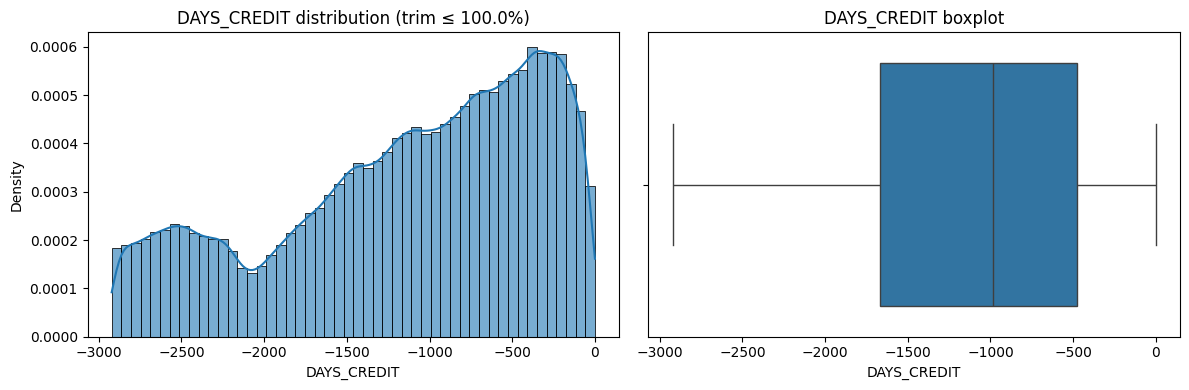

In [47]:
hist_boxplot_numeric(bureau, 'DAYS_CREDIT')

Most credits were take 1-4 years before the Home Credit application. There are a smaller group with older loans

,DAYS_CREDIT_ENDDATE
count,1610875.00
mean,510.52
std,4994.21
min,-42048.00
25%,-1138.00
50%,-330.00
75%,474.00
max,31200.00


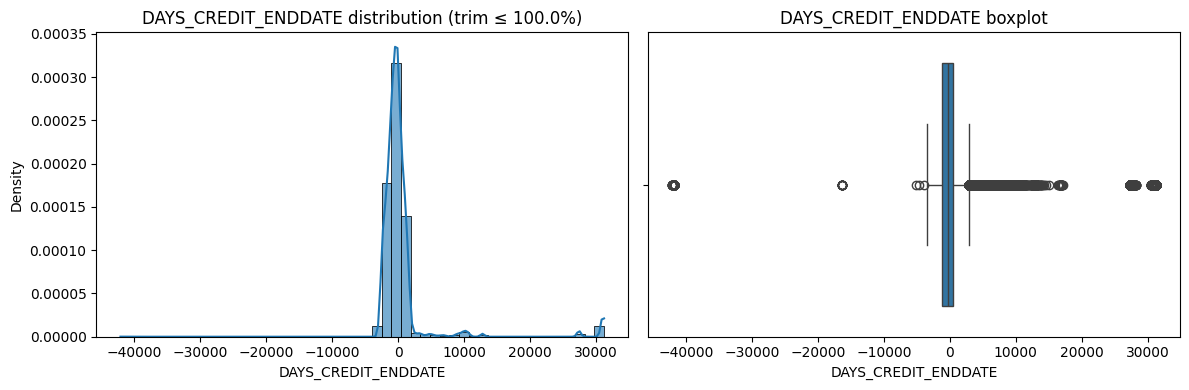

In [48]:
hist_boxplot_numeric(bureau, 'DAYS_CREDIT_ENDDATE')

Majority close to 0, but there are extremely outliers.
Positive values = active credits with time left to maturity.
Negative values = closed loans, since end date is in the past.

,DAYS_CREDIT_UPDATE
count,1716428.00
mean,-593.75
std,720.75
min,-41947.00
25%,-908.00
50%,-395.00
75%,-33.00
max,372.00


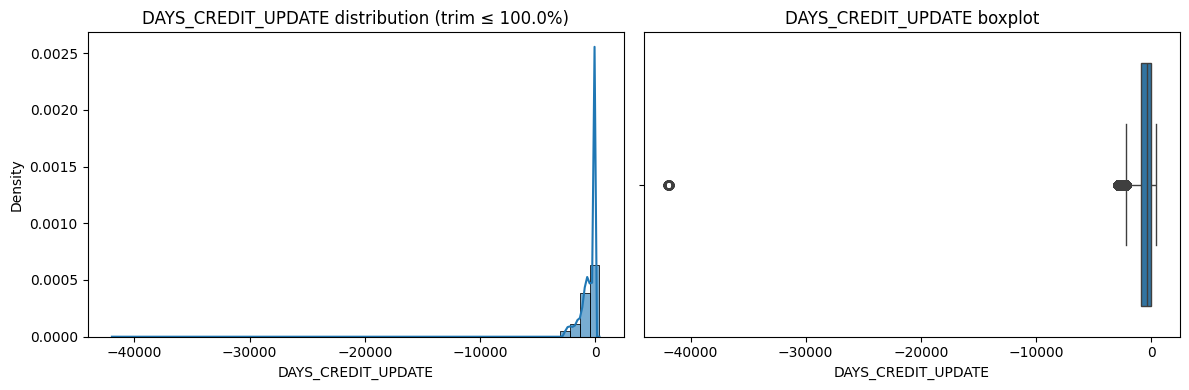

In [49]:
hist_boxplot_numeric(bureau, 'DAYS_CREDIT_UPDATE')

Around 594 days (1.6 years) before loan application did last information about the Credit Bureau credit come.

,CREDIT_DAY_OVERDUE
count,1716428.00
mean,0.82
std,36.54
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,2792.00


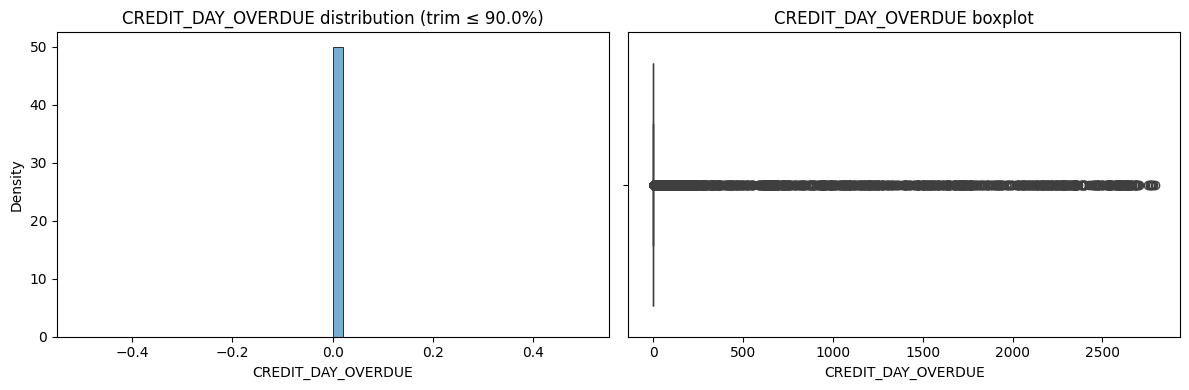

In [50]:
hist_boxplot_numeric(bureau, 'CREDIT_DAY_OVERDUE', trim_upper=0.9)

Around 0.82 days past due on CB credit at the time of application for related loan in our sample. Almost all credits have no overdue.

,CNT_CREDIT_PROLONG
count,1716428.00
mean,0.01
std,0.10
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,9.00


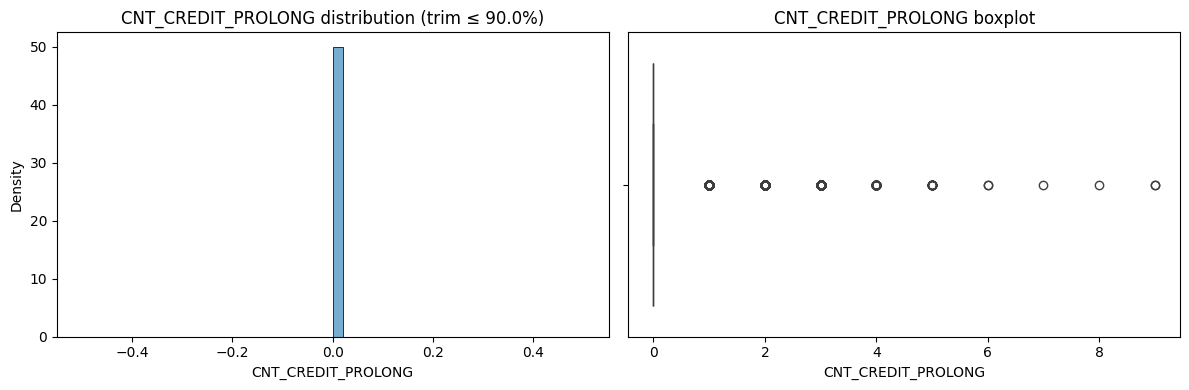

In [51]:
hist_boxplot_numeric(bureau, 'CNT_CREDIT_PROLONG', trim_upper=0.9)

The probability is 0.64% that a credit Bureau is prolonged. There are few outliers.

,AMT_CREDIT_SUM
count,1716415.00
mean,354994.59
std,1149811.34
min,0.00
25%,51300.00
50%,125518.50
75%,315000.00
max,585000000.00


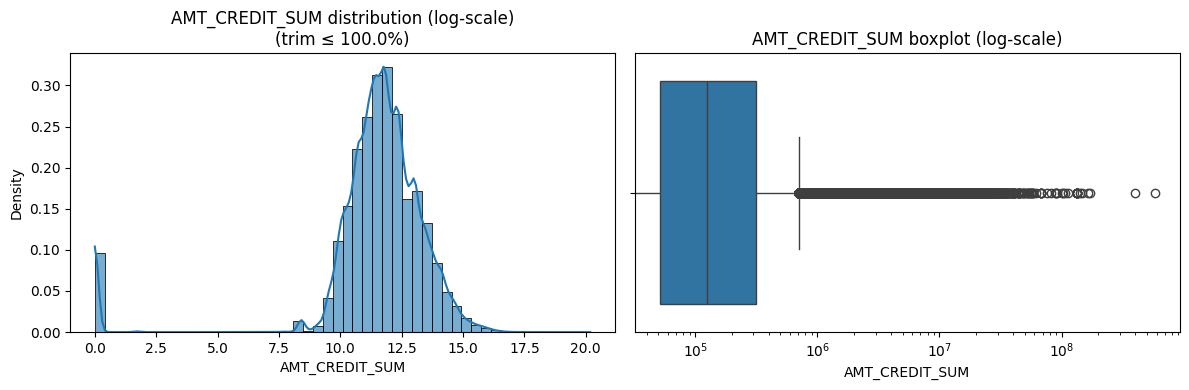

In [52]:
hist_boxplot_numeric(bureau, 'AMT_CREDIT_SUM', log_boxplot=True)

There are an average of 125518 current credit amount for the Credit Bureau credit. Heavily right-skewed distribution (expected for monetary data).

,AMT_CREDIT_SUM_DEBT
count,1458759.00
mean,137085.12
std,677401.13
min,-4705600.50
25%,0.00
50%,0.00
75%,40153.50
max,170100000.00


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


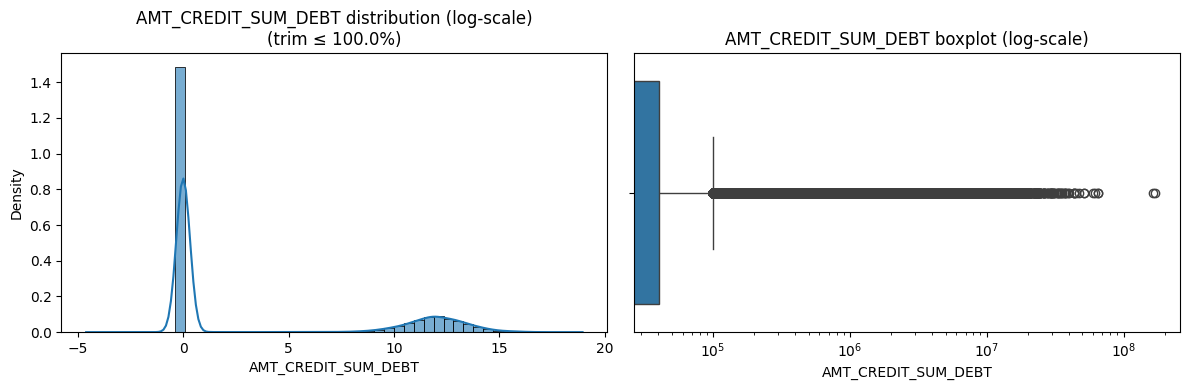

In [53]:
hist_boxplot_numeric(bureau, 'AMT_CREDIT_SUM_DEBT', log_boxplot=True)

Current debt on Credit Bureau credit are mostly 0, closed loans or fully repaid. There also are a smaller subset of positive debt values, these are ongoing loans.


,AMT_CREDIT_SUM_OVERDUE
count,1716428.00
mean,37.91
std,5937.65
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,3756681.00


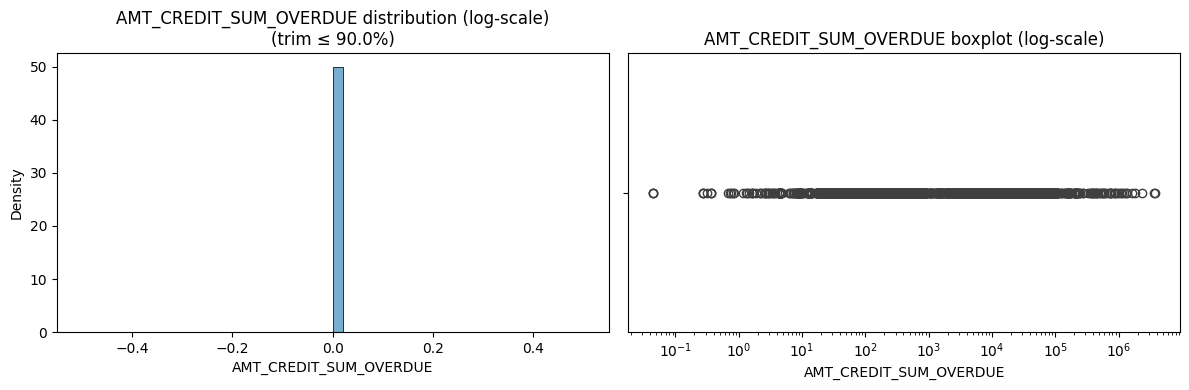

In [54]:
hist_boxplot_numeric(bureau, 'AMT_CREDIT_SUM_OVERDUE', log_boxplot=True, trim_upper=0.90)

Current amount overdue on Credit Bureau credit is zero-inflated.

## EDA Insights Summary

| Theme | Key Observation | Credit Risk Implication | ETL / Modeling Action |
|--------|------------------|--------------------------|-----------------------|
| Loan Type | Cash loans dominate portfolio (8.3% default vs 5.5% revolving) | Product-level differences affect risk profile | Keep product category |
| Gender | Males default 3 pp higher than females | Demographic segmentation signal | Retain gender indicator |
| Region | High-risk regions show 2× higher PD | Proxy for socioeconomic factors | Keep; avoid redundancy with city-based rating |
| Education | Inverse correlation with default | Financial literacy proxy | Retain categorical |
| Employment | Unstable income types (unemployed, maternity leave) default up to 40% | Strong predictive feature | Keep |
| Dependents | More children = higher default | Household burden indicator | Cap at 4+ and create binary “has_children” |
| Occupation | Strong gradient by skill level | Income stability proxy | keep |
| Bureau Data | Most external loans closed; strong consumer credit presence | Historical repayment behavior available | Aggregate bureau metrics per customer |
| EXT_SOURCE | Strongest numeric predictors (abs(r)≈0.16–0.18) | External creditworthiness proxy | Central input for model baseline |
